<a href="https://colab.research.google.com/github/sherlockieee/cs166/blob/main/CS166_LBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
from enum import Enum
import numpy as np
from collections import deque
from typing import Dict, List


class TrafficLightColor(Enum):
    # Traffic light color
    RED = "RED"
    GREEN = "GREEN"


class Turn(Enum):
    LEFT = "LEFT"
    RIGHT = "RIGHT"
    STRAIGHT = "STRAIGHT"


In [51]:
class Road:
    def __init__(
        self,
        name,
        next_roads=None,
        intersection=None,
        length=100,
        new_config = None
    ):
        self.name = name
        self.length = length
        self.next_roads = next_roads
        self.intersection = intersection

        self.update_config(new_config)

        # Keep track of the time steps and average traffic flow at each step
        self.state = deque()
        self.average_traffic_flow = []
        self.average_speed = []

    def clear(self):
        self.state = deque()

    def update_config(self, new_config):
        if new_config is None:
            return
        for key, val in new_config.items():
            setattr(self, key, val)

    def get_next_road(self, turn: Turn):
        if not self.next_roads:
            return None

        return self.next_roads[turn]

    def add_car(self, car, new_idx):
        # if we already have a car that is at a smaller index
        # we cannot add a new car at this index
        if self.state and self.state[-1].idx <= new_idx:
            return False
        self.state.append(car)
        return True

    def _get_intersection_obstacle_dist(self, car_idx):
        if not self.intersection:
            return float("inf")
        elif self.intersection.traffic_light.is_green(self):
            return float("inf")
        else:
            return self.length - car_idx 

    def update(self):
        prev_idx = None
        total_speed = 0
        add_car_back = None

        for i in range(len(self.state)):
            # get the leftmost car in the queue
            car = self.state.popleft()
            car_idx = car.idx

            # if it's the first car, calculate its obstacle distance
            # with regards to the intersection
            if i == 0:
                obstacle_dist = self._get_intersection_obstacle_dist(car_idx)
                car.update(obstacle_dist)
                # if the new index of the first car is beyond the range of the road
                if car.idx >= self.length:
                    # let the car go to the next road if there's one
                    if self.intersection:
                        # if the intersection is full and car cannot turn
                        if not car.turn(new_idx=car.idx - self.length):
                            # store this value so we can add it back later
                            add_car_back = car
                # else the car is still in the road so we can append it back
                else:
                    self.state.append(car)
            # else we only need to worry about the car in front
            else:
                car.update(prev_idx - car_idx)
                self.state.append(car)

            # update previous index
            prev_idx = car_idx

            total_speed += car.speed

        if add_car_back:
            self.state.appendleft(add_car_back)

        self.average_traffic_flow.append(total_speed / self.length)
        if len(self.state) == 0:
            self.average_speed.append(0)
        else: 
            self.average_speed.append(total_speed / len(self.state))

    def __str__(self):
        val = ["." for _ in range(self.length)]
        for car in self.state:
            val[car.idx] = str(car.speed)
        string = self.name + ": " + "".join(val)
        return string


In [52]:



class Car:
    def __init__(self, road: Road, new_config=None):
        self.road = road
        self.idx = 0
        self.max_speed = 5
        self.prob_slow = 0.1
        # by default, we let them turn in all directions with equal probability
        self.turn_directions = {
            Turn.LEFT: 1 / 3,
            Turn.RIGHT: 1 / 3,
            Turn.STRAIGHT: 1 / 3,
        }
        self.update_config(new_config)
        self.speed = np.random.randint(self.max_speed + 1)
        

    def update_config(self, new_config):
        if new_config is None:
            return
        for key, val in new_config.items():
            setattr(self, key, val)

    def update(self, obstacle_dist):
        # Acceleration
        if self.speed < self.max_speed:
            self.speed += 1

        # Deceleration
        if self.speed >= obstacle_dist:
            self.speed = obstacle_dist - 1

        # Randomization
        if self.speed > 0:
            self.speed -= np.random.random() < self.prob_slow

        # update location
        self.idx = self.idx + self.speed

    def turn(self, new_idx: int):
        turn_direction = np.random.choice(
            list(self.turn_directions.keys()), p=list(self.turn_directions.values())
        )

        turn_road = self.road.get_next_road(turn_direction)
        # if the car is at the end of the street, we cannot turn
        if not turn_road:
            return False

        # if the car can turn because there's space in the new road
        if turn_road.add_car(self, new_idx):
            self.road = turn_road
            self.idx = new_idx
            return True

        # else the car will remain in the old road but at the end of the road
        self.idx = self.road.length - 1
        return False


In [53]:
class TrafficLight:
    def __init__(self, roads: List[Road]):
        self.roads = roads
        self.state = [TrafficLightColor.RED for _ in range(4)]
        self.state[0] = TrafficLightColor.GREEN
        self.green_light_time = 15
        self.time_in_cycle = 0

    def clear(self):
        self.state = [TrafficLightColor.RED for _ in range(4)]
        self.state[0] = TrafficLightColor.GREEN
        self.time_in_cycle = 0

    def update_config(self, new_config):
        for key, val in new_config.items():
            setattr(self, key, val)

    def update(self):
        self.time_in_cycle = (self.time_in_cycle + 1) % (self.green_light_time * 4)
        self.state = [TrafficLightColor.RED for _ in range(4)]
        self.state[self.time_in_cycle // self.green_light_time] = TrafficLightColor.GREEN

    def is_green(self, road):
        road_idx = self.roads.index(road)
        return self.state[road_idx] == TrafficLightColor.GREEN

    def __str__(self):
        green_light_road = self.roads[self.state.index(TrafficLightColor.GREEN)]
        return f"Green light at {green_light_road}"


In [54]:
from typing import List

class FourWayIntersection:
    def __init__(self, name, roads: List[Road]):
        # roads listed in clockwise direction
        self.name = name
        for road in roads:
            road.intersection = self
        self.traffic_light = TrafficLight(roads)

    def update_config(self, new_config):
        if "FourWayIntersection" in new_config:
            for key, val in new_config["FourWayIntersection"].items():
                setattr(self, key, val)
        if "TrafficLight" in new_config:
            self.traffic_light.update_config(new_config["TrafficLight"])

    def clear(self):
        self.traffic_light.clear()

    def update(self):
        # update traffic light
        self.traffic_light.update()

    def __repr__(self) -> str:
        string = f"Intersection {self.name}:"
        string += "\n" + str(self.traffic_light)
        return string

    def __str__(self) -> str:
        string = f"Intersection {self.name}:"
        string += "\n" + str(self.traffic_light)
        return string


In [70]:
import matplotlib.pyplot as plt


class Simulation:
    def __init__(
        self,
        roads,
        intersections: List[FourWayIntersection],
        road_add_car_freq_dict,
        new_config = None
    ):
        self.roads = roads
        self.intersections = intersections
        self.time = 0
        self.road_add_car_freq_dict = road_add_car_freq_dict
        self.car_config = None
        self._update_config(new_config)


        self.average_flow = []
        self.average_speed = []

        for road in self.roads:
            road.clear()
        
        for intersection in self.intersections:
            intersection.clear()

        self._add_cars()

    def _update_config(self, new_config):
        if new_config is None:
            return
        if "Simulation" in new_config:
            for key, val in new_config["Simulation"].items():
                setattr(self, key, val)
        
        if "FourWayIntersection" in new_config or "TrafficLight" in new_config:
            for intersection in self.intersections:
                intersection.update_config(new_config)

        if "Road" in new_config:
            for road in self.roads:
                road.update_config(new_config["Road"])

        if "Car" in new_config:
            self.car_config = new_config["Car"]
        

    def _add_cars(self):
        for road, freq in self.road_add_car_freq_dict.items():
            if self.time % freq == 0:
                road.add_car(Car(road, new_config=self.car_config), 0)
            
    def update(self):
        self.time += 1

        flow = 0
        speed = 0
        for intersection in self.intersections:
            intersection.update()
        for road in self.roads:
            road.update()
            flow += road.average_traffic_flow[-1]
            speed += road.average_speed[-1]

        
        self.average_flow.append(flow/ len(self.roads))
        self.average_speed.append(speed/ len(self.roads))

        self._add_cars()

            



    def __repr__(self):
        string = f"At {self.time}s:\n"
        for intersection in self.intersections:
            string += str(intersection.traffic_light) + "\n"
        for road in self.roads:
            string += str(road) + "\n"
        return string

    def run(self, max_time, debug=False):
        while self.time < max_time:
            self.update()
            if debug:
                print(self)

    def display(self):
        plt.plot(self.average_flow)
        plt.xlabel("Time (s)")
        plt.ylabel("Average traffic density")
        plt.show()
        plt.plot(self.average_speed)
        plt.xlabel("Time (s)")
        plt.ylabel("Average speed of cars on road")
        plt.show()





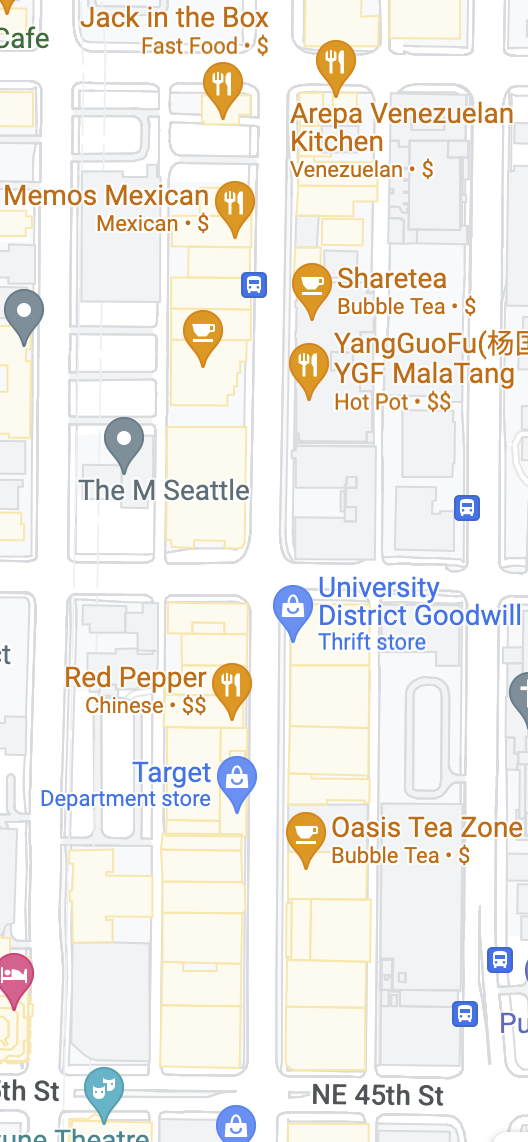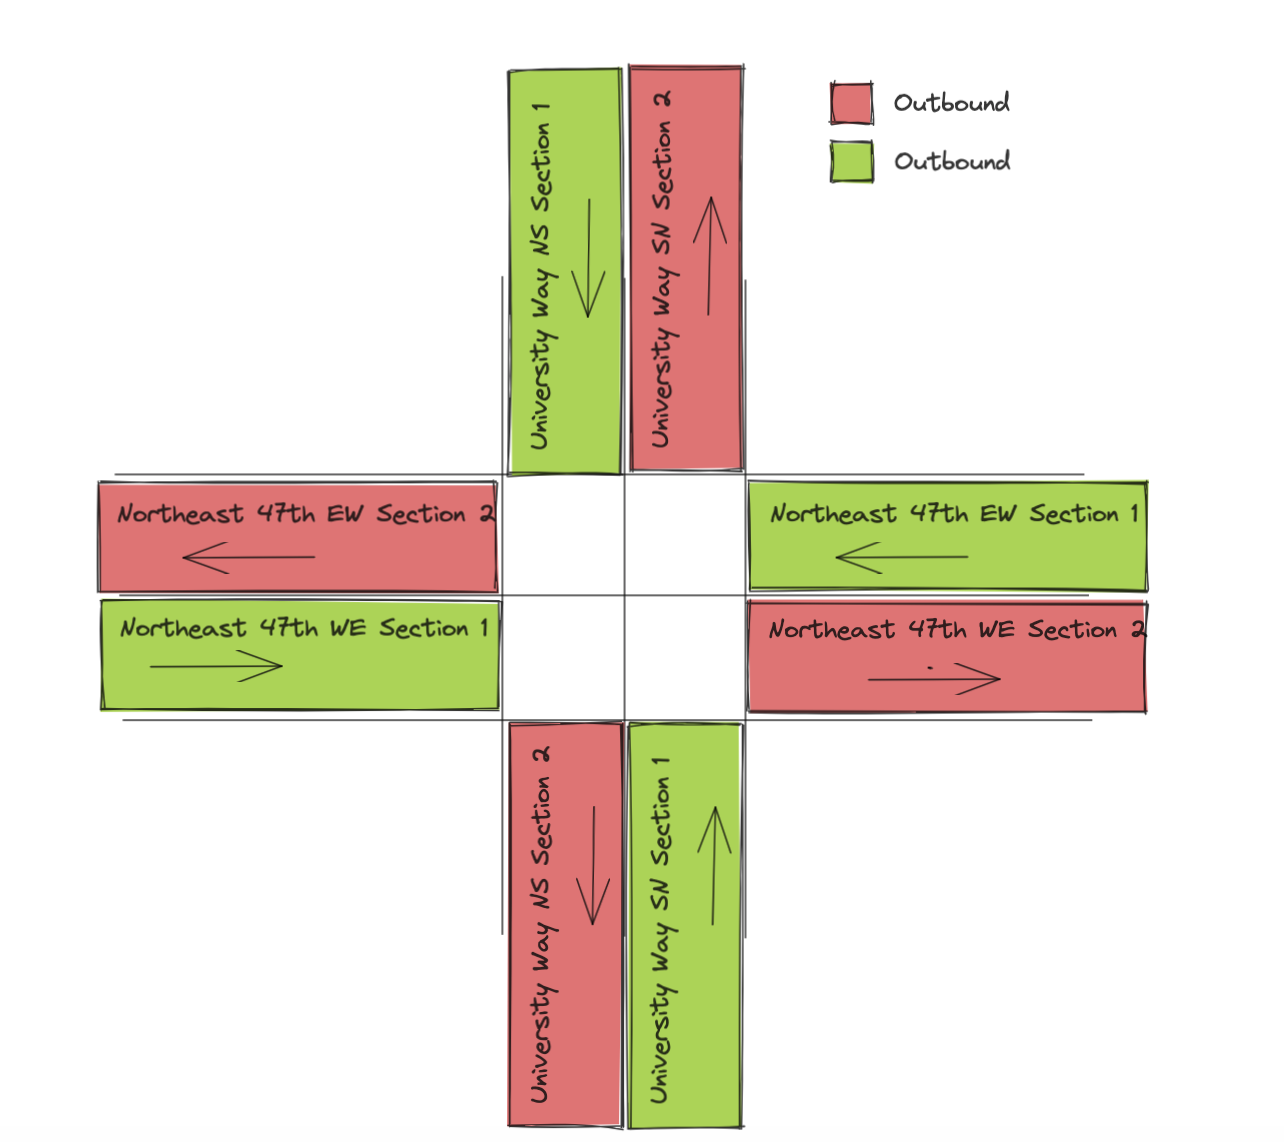

In [56]:


# create all inbound roads first
NorthEast47WE_Section2 = Road("North East 47th WE - Section 2")
NorthEast47EW_Section2 = Road("North East 47th EW - Section 2")
UniversityWayNS_Section2 = Road("University Way NS - Section 2")
UniversityWaySN_Section2 = Road("University Way SN - Section 2")

NorthEast47WE_Section1 = Road(
    "North East 47th WE - Section 1",
    next_roads={
        Turn.LEFT: UniversityWaySN_Section2,
        Turn.RIGHT: UniversityWayNS_Section2,
        Turn.STRAIGHT: NorthEast47WE_Section2,
    },
)
NorthEast47EW_Section1 = Road(
    "North East 47th EW - Section 1",
    next_roads={
        Turn.LEFT: UniversityWayNS_Section2,
        Turn.RIGHT: UniversityWaySN_Section2,
        Turn.STRAIGHT: NorthEast47EW_Section2,
    },
)
UniversityWayNS_Section1 = Road(
    "University Way NS - Section 1",
    next_roads={
        Turn.LEFT: NorthEast47WE_Section2,
        Turn.RIGHT: NorthEast47EW_Section2,
        Turn.STRAIGHT: UniversityWayNS_Section2,
    },
)
UniversityWaySN_Section1 = Road(
    "University Way SN - Section 1",
    next_roads={
        Turn.LEFT: NorthEast47EW_Section2,
        Turn.RIGHT: NorthEast47WE_Section2,
        Turn.STRAIGHT: UniversityWaySN_Section2,
    },
)


intersection = FourWayIntersection(
    "UW - NE47",
    roads=[
        NorthEast47WE_Section1,
        UniversityWayNS_Section1,
        NorthEast47EW_Section1,
        UniversityWaySN_Section1,
    ],
    
)

roads = [
    NorthEast47EW_Section2,
    NorthEast47WE_Section2,
    UniversityWayNS_Section2,
    UniversityWaySN_Section2,
    NorthEast47EW_Section1,
    NorthEast47WE_Section1,
    UniversityWayNS_Section1,
    UniversityWaySN_Section1,
]




In [57]:
test_configs = {
    "Road": {"length": 5},
    "Car": {
        "max_speed": 1,
        "prob_slow": 0,
        "turn_directions": {
            Turn.STRAIGHT: 1
        }
    },
    "TrafficLight": {"green_light_time": 15},
}

test_simulation = Simulation(
    roads=roads,
    intersections=[intersection],
    road_add_car_freq_dict={
            NorthEast47EW_Section1: 1,
            NorthEast47WE_Section1: 1,
            UniversityWayNS_Section1: 1,
            UniversityWaySN_Section1: 1,
        },
    new_config = test_configs
)


print(test_simulation)

test_simulation.run(10, debug=True)


At 0s:
Green light at North East 47th WE - Section 1: 0....
North East 47th EW - Section 2: .....
North East 47th WE - Section 2: .....
University Way NS - Section 2: .....
University Way SN - Section 2: .....
North East 47th EW - Section 1: 0....
North East 47th WE - Section 1: 0....
University Way NS - Section 1: 0....
University Way SN - Section 1: 0....

At 1s:
Green light at North East 47th WE - Section 1: 11...
North East 47th EW - Section 2: .....
North East 47th WE - Section 2: .....
University Way NS - Section 2: .....
University Way SN - Section 2: .....
North East 47th EW - Section 1: 01...
North East 47th WE - Section 1: 11...
University Way NS - Section 1: 11...
University Way SN - Section 1: 11...

At 2s:
Green light at North East 47th WE - Section 1: 0.1..
North East 47th EW - Section 2: .....
North East 47th WE - Section 2: .....
University Way NS - Section 2: .....
University Way SN - Section 2: .....
North East 47th EW - Section 1: 0.1..
North East 47th WE - Section 1

At 0s:
Green light at North East 47th WE - Section 1: 1...................
North East 47th EW - Section 2: ....................
North East 47th WE - Section 2: ....................
University Way NS - Section 2: ................................................................................
University Way SN - Section 2: ................................................................................
North East 47th EW - Section 1: 0...................
North East 47th WE - Section 1: 1...................
University Way NS - Section 1: 3...............................................................................
University Way SN - Section 1: 2...............................................................................



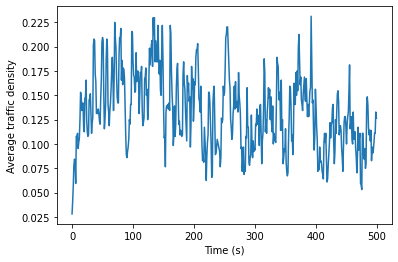

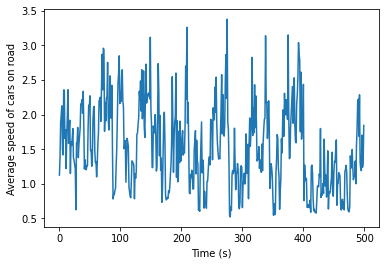

In [58]:
NorthEast47EW_Section1.length = 20
NorthEast47EW_Section2.length = 20
NorthEast47WE_Section1.length = 20
NorthEast47WE_Section2.length = 20
UniversityWayNS_Section1.length = 80
UniversityWayNS_Section2.length = 80
UniversityWaySN_Section1.length = 80
UniversityWaySN_Section2.length = 80


simulation_config = {
    "Car": {
        "max_speed": 5,
        "prob_slow": 0.3,
        "turn_directions": {
            Turn.STRAIGHT: 0.6,
            Turn.LEFT: 0.2,
            Turn.RIGHT: 0.2
        }
    },
    "TrafficLight": {"green_light_time": 30},
}



simulation = Simulation(
    roads=roads,
    intersections=[intersection],
    road_add_car_freq_dict={
            NorthEast47EW_Section1: 7,
            NorthEast47WE_Section1: 7,
            UniversityWayNS_Section1: 3,
            UniversityWaySN_Section1: 3,
        },
    new_config = simulation_config
)

print(simulation)
simulation.run(500)
simulation.display()

In [59]:
import scipy.stats as st


def plot_confidence_interval(reps = 1000, time = 1000, config = simulation_config):
    traffic_density_results = []
    speed_results = []
    for _ in range(reps):
        simulation = Simulation(
        roads=roads,
        intersections=[intersection],
        road_add_car_freq_dict={
                NorthEast47EW_Section1: 7,
                NorthEast47WE_Section1: 7,
                UniversityWayNS_Section1: 3,
                UniversityWaySN_Section1: 3,
            },
        new_config = config)
        simulation.run(time)
        traffic_density_results.append(simulation.average_flow[-1])
        speed_results.append(simulation.average_speed[-1])

    return_vals = []

    for results, label in [(traffic_density_results, "Average traffic density"), (speed_results, "Average speed")]:
        mean = np.mean(results)
        percentile_25 = np.percentile(results, 25)
        percentile_75 = np.percentile(results, 75)

        plt.hist(results)
        plt.axvline(mean, color = 'black', label = "Mean")
        plt.axvline(percentile_25, color = 'black', linestyle='--', label = '25th percentile')
        plt.axvline(percentile_75, color = 'black', linestyle='--', label = '75th percentile')
        plt.xlabel(label)
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

        return_vals.append((mean, percentile_25, percentile_75))
    
    return return_vals

    



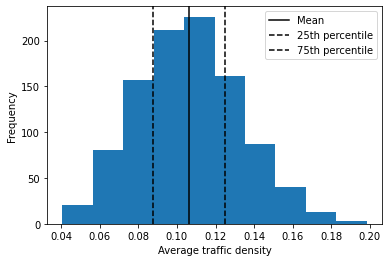

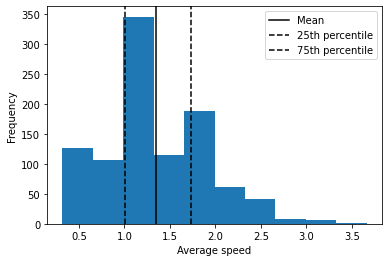

[(0.10630625, 0.0875, 0.125),
 (1.3478258543341826, 1.0050433898410334, 1.731082716223362)]

In [60]:
plot_confidence_interval()

## Theoretical Analysis

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def mfa(v, density, p_slow, road_length, intersection = False):
    '''
    Calculate the updated distribution over speeds given the current
    distribution by applying the MFA traffic rules.

    Inputs:
    
        v (list of float) The car speed probability vector. v[i] is the
        probability that a car is moving at speed i.

        density (float) The average number of cars per cell on the road.
        
        p_slow (float) The probability of random slow-down.

        road_length (int) The length of the road, to calculate changes 
        when there's traffic light

        intersection (boolean) Return True if there is an intersection
        at the end of the road
    
    Returns: A new, updated car speed probability vector.
    '''
    v_max = len(v) - 1
    new_v = [0] * len(v)  # The updated speed probability vector
    for v_from in range(v_max + 1):
        
        # Current speed, will be updated below
        speed = v_from
        
        # Accelerate
        if speed < v_max:
            speed += 1
        
        # Brake when there is a car in front at each distance from 1 to speed
        for distance in range(1, speed + 1):
            # Probability that a car is in front at a particular distance
            car_at_distance = (1-density)**(distance-1) * density
            # If we also need to take into account red light
            if intersection:
                car_at_distance += 0.75 * 1/road_length
            
            if distance > 1:
                new_v[distance-1] += v[v_from] * car_at_distance * (1-p_slow)
                new_v[distance-2] += v[v_from] * car_at_distance * p_slow
            else:
                new_v[distance-1] += v[v_from] * car_at_distance
        
        # No cars in front up to distance == speed
        new_v[speed] += v[v_from] * (1-density)**speed * (1-p_slow)
        new_v[speed-1] += v[v_from] * (1-density)**speed * p_slow
        
    #scaling new_v to have sum of 1
    new_v = np.array(new_v)/ sum(new_v)
    return new_v


def average_speed(v):
    return np.sum(np.array(v) * np.arange(len(v)))

def average_flow(v, density):
    return density * average_speed(v)

max_speed = 5
p_slow = 0.3

university_section_1_density = 1/7
northeast_section_1_density = 1/3
university_section_2_density = (1/3 * 0.6) + (1/7 * 0.2) + (1/7 * 0.2)
northeast_section_2_density =  (1/7 * 0.6) + (1/3 * 0.2) + (1/3 * 0.2)

university_section_1 = (university_section_1_density, 80, True)
university_section_2 = (university_section_2_density, 80, False)

northeast_section_1 = (northeast_section_1_density, 20, True)
northeast_section_2 = (northeast_section_2_density, 20, False)

all_roads = [university_section_1, university_section_2, northeast_section_1, northeast_section_2]

mfa_flow_results = []

for density, road_length, has_intersection in all_roads:
    v = [1/(max_speed + 1)] * (max_speed + 1)
    for i in range(100):  
        v = mfa(v, density, p_slow, road_length, has_intersection)
    mfa_flow_results.append(average_flow(v, density))


print(np.mean(mfa_flow_results))

0.24856929776728104


In [95]:
import scipy.stats as st

density_list = [1/i for i in range(2, 8)]

intersection = FourWayIntersection(
    "UW - NE47",
    roads=[
        NorthEast47WE_Section1,
        UniversityWayNS_Section1,
        NorthEast47EW_Section1,
        UniversityWaySN_Section1,
    ],
    
)

roads = [
    NorthEast47EW_Section2,
    NorthEast47WE_Section2,
    UniversityWayNS_Section2,
    UniversityWaySN_Section2,
    NorthEast47EW_Section1,
    NorthEast47WE_Section1,
    UniversityWayNS_Section1,
    UniversityWaySN_Section1,
]

def plot_theoretical_versus_simulation(reps = 100, time = 100, density_list = density_list):
    simulation_results = []
    simulation_25_results = []
    simulation_75_results = []
    theoretical_results = []

    for density in density_list:
        simulation_result = []
        #run simulation
        for _ in range(reps):
            simulation = Simulation(
            roads=roads,
            intersections=[intersection],
            road_add_car_freq_dict={
                    NorthEast47EW_Section1: 1/density,
                    NorthEast47WE_Section1: 1/density,
                    UniversityWayNS_Section1: 1/density,
                    UniversityWaySN_Section1: 1/density,
                })
            simulation.run(time)
            simulation_result.append(simulation.average_flow[-1]) 

        simulation_results.append(np.mean(simulation_result))
        simulation_25_results.append(np.percentile(simulation_result, 25))
        simulation_75_results.append(np.percentile(simulation_result, 75))


        #theoretical analysis
        all_roads = [(density, road.length, True if road.intersection else False) for road in roads]
        mfa_flow_results = []
        for density, road_length, has_intersection in all_roads:
            v = [1/(max_speed + 1)] * (max_speed + 1)
            for i in range(time):  
                v = mfa(v, density, p_slow, road_length, has_intersection)
            mfa_flow_results.append(average_flow(v, density))
        theoretical_results.append(np.mean(mfa_flow_results))

    plt.plot(density_list, simulation_results,label = 'Simulation result - Mean')
    plt.plot(density_list, simulation_25_results,  label = 'Simulation result - 25th percentile')
    plt.plot(density_list, simulation_75_results, label = 'Simulation result - 75th percentile')
    plt.plot(density_list, theoretical_results,  label = 'Theoretical approximation')
    plt.legend()
    plt.xlabel("Average car density")
    plt.ylabel("Average traffic flow")
    plt.show()

    



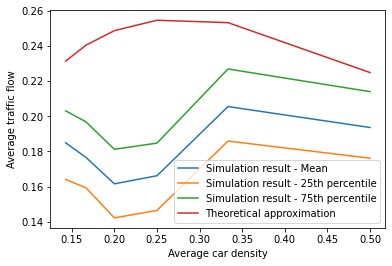

In [96]:
plot_theoretical_versus_simulation()